# Stage 10a — Modeling: Linear Regression (Lecture)

**Theme:** Assumption-first modeling; interpretation as storytelling.

This notebook generates its own synthetic finance-flavored dataset (no external files) and walks through:
1) Fit a baseline linear regression
2) Diagnose residuals (linearity, homoscedasticity, normality, independence)
3) Add a polynomial term to improve specification (still linear regression)
4) Optional statsmodels cameo for interpretive output

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st
sns.set()
np.random.seed(42)

## 1) Generate synthetic finance-like data
- Factors: market (mkt_excess), size, value, momentum
- Target: asset_excess = β·factors + β2·momentum^2 + heteroscedastic noise (∝ |mkt_excess|)
- 240 business days (~1 year)

In [2]:
n = 240
dates = pd.bdate_range(start='2024-01-02', periods=n)

# Simulate factor returns
mkt_excess = np.random.normal(0, 0.01, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.008, size=n)
momentum = np.random.normal(0, 0.006, size=n)

# True coefficients
beta0 = 0.0002
beta_mkt = 0.8
beta_size = 0.3
beta_value = -0.2
beta_mom = 0.4
beta_mom2 = 4.0  # introduce a mild quadratic effect

# Heteroscedastic noise: scale increases with |market|
noise_scale = 0.004 + 0.6 * np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)

asset_excess = (
    beta0 + beta_mkt * mkt_excess + beta_size * size + beta_value * value + beta_mom * momentum
    + beta_mom2 * (momentum ** 2)
    + eps
)

df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-01-02,0.004967,-0.006340,-0.001023,0.001847,0.007715
1,2024-01-03,-0.001383,-0.000918,-0.007644,-0.010261,0.003083
2,2024-01-04,0.006477,0.004040,-0.012852,-0.008089,0.007740
3,2024-01-05,0.015230,0.006926,0.001628,0.004460,0.025315
4,2024-01-08,-0.002342,-0.009602,-0.006051,0.001025,-0.003415


In [3]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,240,2024-06-16 21:36:00,2024-01-02 00:00:00,2024-03-25 18:00:00,2024-06-17 12:00:00,2024-09-09 06:00:00,2024-12-02 00:00:00,NaN
mkt_excess,240.0,-0.000024,-0.026197,-0.006855,0.000623,0.005931,0.038527,0.009708
size,240.0,0.000285,-0.02593,-0.005043,0.000091,0.005464,0.024631,0.00792
value,240.0,-0.000508,-0.021575,-0.006065,-0.000492,0.004771,0.020587,0.007996
momentum,240.0,0.000738,-0.013193,-0.003338,0.001046,0.00409,0.015794,0.005674
asset_excess,240.0,0.001643,-0.03165,-0.005768,0.001299,0.009222,0.050753,0.012698


## 2) Baseline model (no polynomial term)
We start with `X = [mkt_excess, size, value, momentum]` and `y = asset_excess`.
- Split 80/20
- Fit and score (R², RMSE)
- Plot residual diagnostics

In [4]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2, rmse

r2, rmse

(0.400332111782022, np.float64(0.010904384530872816))

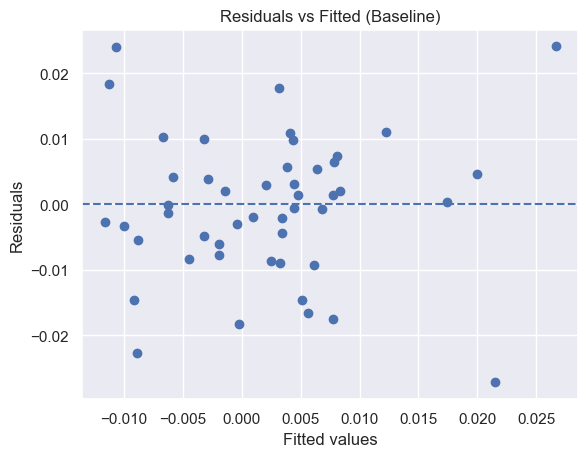

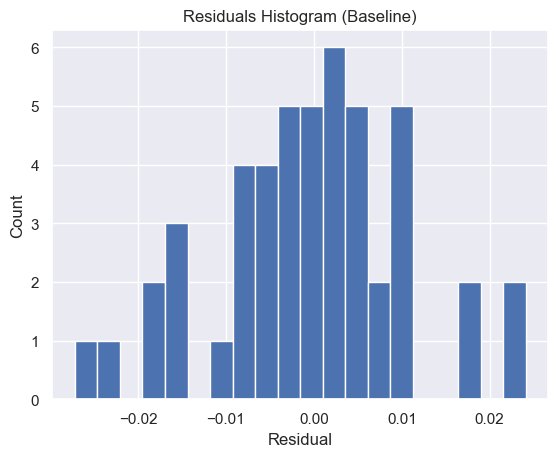

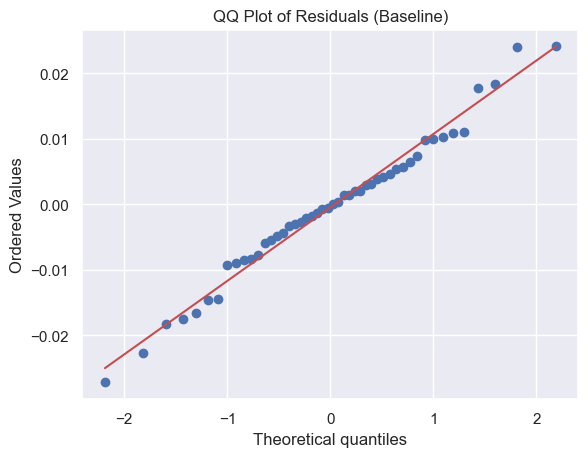

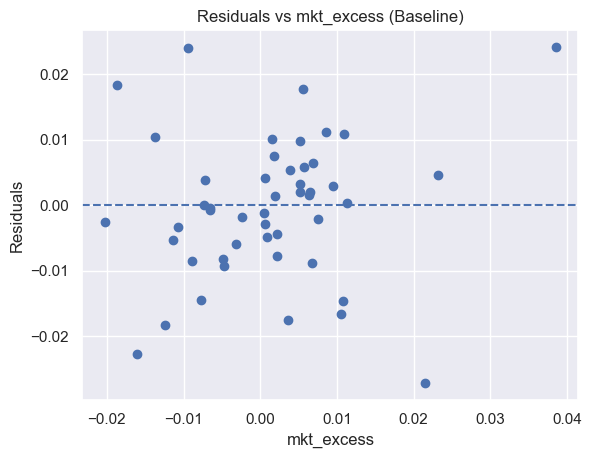

In [5]:
resid = y_test - y_pred
fitted = y_pred

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Fitted (Baseline)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.figure()
plt.hist(resid, bins=20)
plt.title('Residuals Histogram (Baseline)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.figure()
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals (Baseline)')
plt.show()

plt.figure()
plt.scatter(X_test['mkt_excess'], resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs mkt_excess (Baseline)')
plt.xlabel('mkt_excess')
plt.ylabel('Residuals')
plt.show()